# Problem Set 3

This is a problem about Abalone.

The overall question revolves around abalone rings. The target variable is rings because it is a predictor of age. 


<a id="contents"></a>
# Contents

1. [ETL](#step1)
2. [EDA](#step2)
3. [Statistical and Mathematical Modeling of the Target Variable](#step3)


In [1]:
import numpy as np
import random as py_random
import numpy.random as np_random
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from tabulate import tabulate
import math
from scipy.stats import norm
from scipy.stats import lognorm

import statsmodels.api as sm

sns.set(style="whitegrid")

## 1 <a id="step1">(ETL) Extract, Transform, Load the Data</a>
<a href="#contents">^ Contents</a>

This is the data dictionary for the Abalone data:

```
Description of fields in abalone data.

Name            Data Type    Meas.    Description
----            ---------    -----    -----------
Sex             nominal               M, F, and I (infant)
Length          continuous    mm      Longest shell measurement
Diameter        continuous    mm      perpendicular to length
Height          continuous    mm      with meat in shell
Whole weight    continuous    grams   whole abalone
Shucked weight  continuous    grams   weight of meat
Viscera weight  continuous    grams   gut weight (after bleeding)
Shell weight    continuous    grams   after being dried
Rings           integer               +1.5 gives the age in years
```

The first step is to load the data from its remote location into a dataframe and to make sure we have the data:

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/abalone.original.csv")

Let's look at the overall characteristics of the data to make sure it is loaded correctly. First, let's get the basic data frame info:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4176 entries, 0 to 4175
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   M       4176 non-null   object 
 1   91      4176 non-null   int64  
 2   73      4176 non-null   int64  
 3   19      4176 non-null   int64  
 4   102.8   4176 non-null   float64
 5   44.9    4176 non-null   float64
 6   20.2    4176 non-null   float64
 7   30      4176 non-null   float64
 8   15      4176 non-null   int64  
dtypes: float64(4), int64(4), object(1)
memory usage: 293.8+ KB


There are 4176 entries for each variable so there are no missing values. There are 8 numerical variables and 1 categorical variable. Let's look at the first few rows:

In [4]:
df.head()

,M,91,73,19,102.8,44.9,20.2,30,15
0,M,70,53,18,45.1,19.9,9.7,14.0,7
1,F,106,84,27,135.4,51.3,28.3,42.0,9
2,M,88,73,25,103.2,43.1,22.8,31.0,10
3,I,66,51,16,41.0,17.9,7.9,11.0,7
4,I,85,60,19,70.3,28.2,15.5,24.0,8


We immediately notice that the dataframe does not have column labels. We can add these in according to the data dictionary provided above.

In [5]:
df.columns = ['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings']
df.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,70,53,18,45.1,19.9,9.7,14.0,7
1,F,106,84,27,135.4,51.3,28.3,42.0,9
2,M,88,73,25,103.2,43.1,22.8,31.0,10
3,I,66,51,16,41.0,17.9,7.9,11.0,7
4,I,85,60,19,70.3,28.2,15.5,24.0,8


Now we have added column labels to our dataframe. We can see that the 'Whole weight' variable is more than the 'Shucked weight', 'Viscera weight' and 'Shell weight', which is what we would expect. We also note that 'Length', 'Diameter' and 'Height' are all integers, whereas the weight variables are all floating point values. Another thing we notice is that 'Sex' has values of 'M', 'F' and 'I'. The data dictionary defines the 'I' as 'Infant'. 

In [6]:
def freeman_diaconis(data):
    quartiles = stats.mstats.mquantiles( data, [0.25, 0.5, 0.75])
    iqr = quartiles[2] - quartiles[ 0]
    n = len( data)
    h = 2.0 * (iqr/n**(1.0/3.0))
    return int(np.ceil(h))

In [7]:
def histogram_w_whiskers(data, variable_name, zoom=None):
    h = freeman_diaconis(data[variable_name])
    mn = int(data[variable_name].min())
    mx = int(data[variable_name].max())
    bins = [i for i in range( mn, mx, h)]
    print(f"Freeman Diaconis for {variable_name}: {len(bins)} bins")

    observations = len(data)
    empirical_weights = np.ones(observations)/observations # this converts counts to relative frequencies when used in hist()
        
    # start the plot: 2 rows, because we want the boxplot on the first row
    # and the hist on the second
    fig, ax = plt.subplots(
        2, figsize=(7, 5), sharex=True,
        gridspec_kw={"height_ratios": (.7, .3)}  # the boxplot gets 30% of the vertical space
    )

    # the histogram
    ax[0].hist(data[variable_name],bins=bins, color="dimgray", weights=empirical_weights)
    ax[0].set_title(f"{variable_name} distribution - Freeman Diaconis")
    ax[0].set_ylabel("Relative Frequency")
    if zoom:
        ax[0].set_ylim((0, zoom))
    # the box plot
    ax[1].boxplot(data[variable_name], vert=False)
    # removing borders
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    ax[1].set_xlabel(variable_name)

    # and we are good to go
    plt.show()
    plt.close()
    return h

In [8]:
def histogram_trio(data, variable_name, zoom=1.0):
    h = freeman_diaconis(data[variable_name])
    mn = int(data[variable_name].min())
    mx = int(data[variable_name].max())
    bins = [i for i in range( mn, mx, h)]
    print(f"Freeman Diaconis for {variable_name}: {len(bins)} bins")

    observations = len(data)
    empirical_weights = np.ones(observations)/observations # this converts counts to relative frequencies when used in hist()

    fig, ax = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

    fewer_bins = int(len(bins) * .50)
    more_bins = int(len(bins) * 2)

    n, bins, patches = ax[1].hist(data[variable_name], color="DimGray", bins=bins, weights=empirical_weights) # <---
    ax[1].set_xlabel(variable_name)
    ax[1].set_ylabel("Relative Frequency")
    ax[1].set_title(f"Relative Frequency Histogram of {variable_name}")
    ax[1].set_ylim((0, zoom))
    
    n, bins, patches = ax[0].hist(data[variable_name], color="DimGray", bins=fewer_bins, weights=empirical_weights)
    ax[0].set_xlabel(variable_name)
    ax[0].set_ylabel("Relative Frequency")
    ax[0].set_title(f"Relative Frequency Histogram of {variable_name} (Fewer Bins)")
    
    n, bins, patches = ax[2].hist(data[variable_name], color="DimGray", bins=more_bins, weights=empirical_weights)
    ax[2].set_xlabel(variable_name)
    ax[2].set_ylabel("Relative Frequency")
    ax[2].set_title(f"Relative Frequency Histogram of {variable_name} (More Bins)")

    plt.show()
    plt.close()

## 2 <a id="step2">(EDA) Exploratory Data Analysis</a>

## Single Variable EDA

We'll start our EDA by looking at each variable individually, starting with the target variable, *Rings*.

<a href="#Rings">Rings</a><br>
<a href="#Sex">Sex</a><br>
<a href="#Length">Length</a><br>
<a href="#Diameter">Diameter</a><br>
<a href="#Height">Height</a><br>
<a href="#Whole weight">Whole weight</a><br>
<a href="#Shucked weight">Shucked weight</a><br>
<a href="#Viscera weight">Viscera weight</a><br>
<a href="#Shell weight">Shell weight</a><br>

<a id="Rings"></a>
## Rings


The Rings variable is our target variable in our EDA. It is an integer variable measured in number of rings.

**Domain Knowledge**

Abalone have rings for each year of growth. This means that counting the number of rings of an abalone shell is a good measure of the number of years it has been alive. The shell rings are measured by cutting the shell through the cone, then staining it, and then counting the number of rings through a microscope. This process is time-consuming.

Data Source: [ucdavis.edu](https://anson.ucdavis.edu/~haochen/abalone_description.pdf)
Retrieved on October 16, 2023.

Abalone can live to be about 35 to 40 years old.

Data Source: [fisheries.noaa.gov](https://www.fisheries.noaa.gov/species/white-abalone#:~:text=White%20abalone%20live%20about%2035,and%20sperm%20into%20the%20water.)
Retrieved on October 16, 2023.

**Hypothesis**

We predict the number of rings to span anywhere from 1 to 40, as that is the age range for abalone. We expect most ring counts to be closer to 1, and fewer to be closer to 40.

First we start out using the describe() method to get some preliminary summary statistics of our data.

In [9]:
df.Rings.describe()

count    4176.000000
mean        9.932471
std         3.223601
min         1.000000
25%         8.000000
50%         9.000000
75%        11.000000
max        29.000000
Name: Rings, dtype: float64

The summary statistics mostly support our hypothesis. The mean is 9.93 and the median is 9.00. The variable is definitely skewed. The 3rd quartile is 11.00 and the Inter-Quartile Range (IQR) is 3. The minimum is 1.00 while the maximum is 29.00 which is 29x larger.

Now we use a histogram using Freeman Diaconis bins as well as a box-and-whiskers plot. These charts will allow us to see the distribution better. We expect to see a distribution with some large extreme values.

Freeman Diaconis for Rings: 28 bins


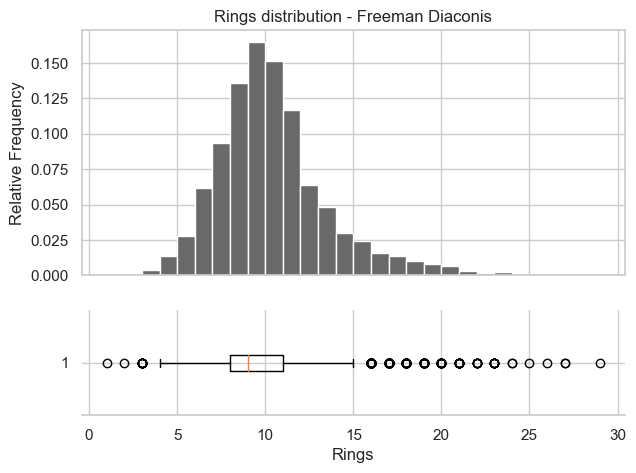

In [10]:
rings_bins = histogram_w_whiskers(df, "Rings")

As we predicted we can see some extreme values to the right. The distribution looks slightly skewed to the right, with most of the values being towards the left. The box and whiskers plot shows the median is right around 9, which is consistent with our preliminary descriptive statistics.

Now we use the $histogram\_trio()$ method to chart three different histograms, each with a different number of bins.

Freeman Diaconis for Rings: 28 bins


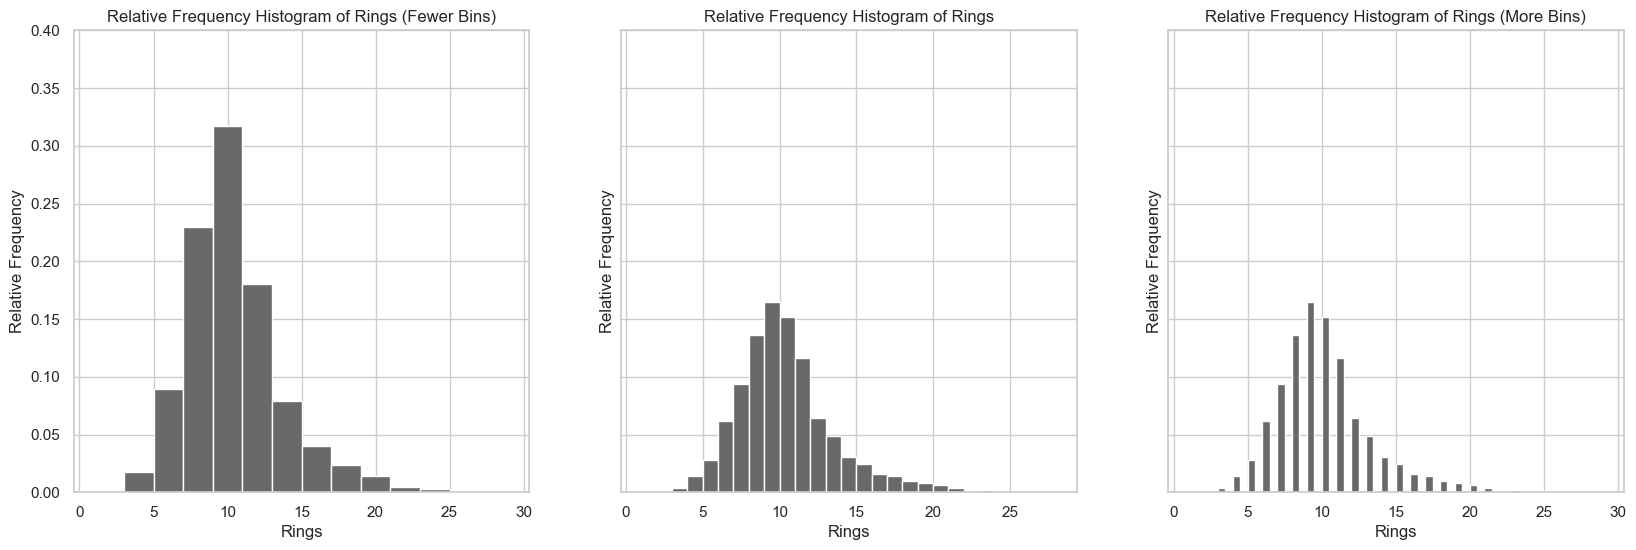

In [11]:
histogram_trio(df, "Rings", zoom=0.4)

After using different numbers of bins, we see that the overall shape of the data remains consistent. Using different bin counts has not illuminated any significant new information about our data.

In summary, we found that abalone ring counts are in the range of 1 to 29, with most being smaller and relatively few being close to 29.

<a id="Sex"></a>
## Sex

The sex variable represents the sex of the abalone. It is a nominal variable with the domain $['M', 'F', 'I']$.

**Domain Knowledge**

Abalone have two sexes, male or female. It is difficult to distinguish the different sexes from their external appearance. Instead, one most look inside at the reproductive organs.

Data Source: [wildlife.ca.gov](https://wildlife.ca.gov/Conservation/Marine/Invertebrates/Abalone#:~:text=The%20sexes%20are%20separate%20but,open%20holes%20in%20their%20shells.)
Retrieved on October 16, 2023.

**Hypothesis**

We predict there to be an approximately even number of male and female abalone, with some also being infants, which we assume means indeterminate sex.

First we start out using value_counts() to get the counts of each sex.

In [12]:
df.Sex.value_counts()

Sex
M    1527
I    1342
F    1307
Name: count, dtype: int64

Interestingly, there are a non-negligible difference in the counts of each sex. There are more than 2000 more male abalone than female, and an approximately even number of infants and female abalone.

1. It is possible that males have longer life expectancies than females, which could be a result of their reproductive cycles.

<a id="Length"></a>
## Length

The length variable is the longest measurement of the abalone shells in our data. It is a continuous numerical variable measured in millimeters.

**Domain Knowledge**

Abalone grow nearly one inch per year for the first few years and then much slower after that. It takes about 5 years for red abalone to grow from 178 mm to 203 mm. After that, it takes about 13 years to grow another 25 mm (about an inch). 

Data Source: [wildlife.ca.gov](https://wildlife.ca.gov/Conservation/Marine/Invertebrates/Abalone#:~:text=Abalone%20grow%20nearly%20one%20inch,years%20to%20grow%20another%20inch.)
Retrieved on October 16, 2023.

**Hypothesis**

We predict that the abalone range from 25 mm to 254 mm, with a majority being around 178 mm and only a few reaching into the larger lengths.

First we start out using the describe() method to get some preliminary summary statistics of our data.

In [13]:
df.Length.describe()

count    4176.000000
mean      104.801724
std        24.020509
min        15.000000
25%        90.000000
50%       109.000000
75%       123.000000
max       163.000000
Name: Length, dtype: float64

The summary statistics partially support our hypothesis. The mean is 105 and the median is 109. The 3rd quartile is 123 and the Inter-Quartile Range (IQR) is 33. The minimum is 15 while the maximum is 163. Our hypothesis range predicted as many as 254 mm, but the largest is 163 inches.

Now we use a histogram using Freeman Diaconis bins as well as a box-and-whiskers plot. These charts will allow us to see the distribution better. We expect to see a distribution with some large extreme values.

Freeman Diaconis for Length: 30 bins


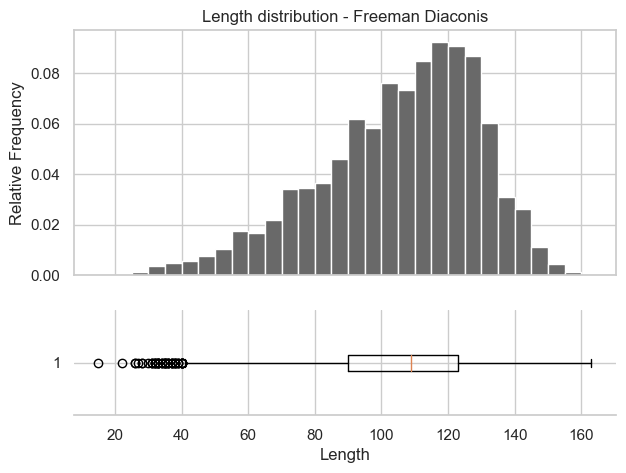

In [14]:
length_bins = histogram_w_whiskers(df, "Length")

Our prediction was off here, as we predicted a majority of values be to the left, but the histogram shows that they are actually more to the right. This result is probably because the abalone grow much faster at earlier ages and then their growth slows down as they get older.

Now we use the $histogram\_trio()$ method to chart three different histograms, each with a different number of bins.

Freeman Diaconis for Length: 30 bins


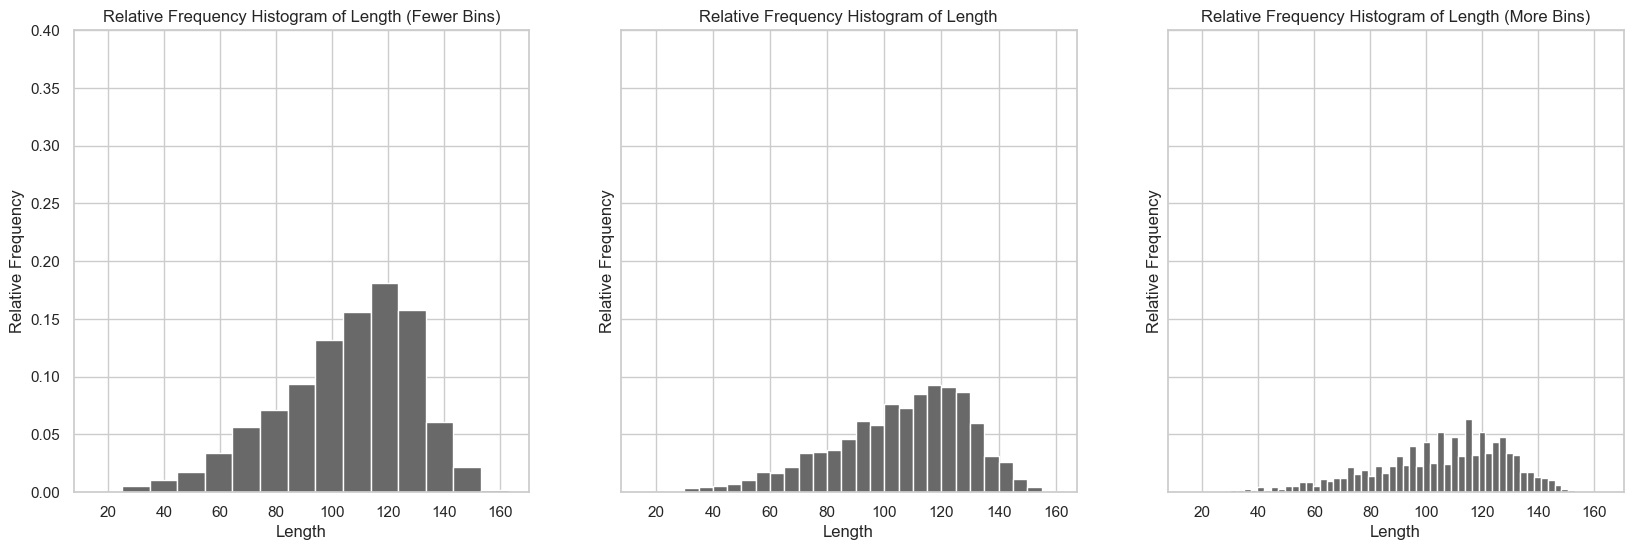

In [15]:
histogram_trio(df, "Length", zoom=0.4)

After using different numbers of bins, we see that the overall shape of the data remains consistent.

In summary, we found that abalone lengths range from 24 to 163 millimeters, with the average being 105 mm long.

<a id="Diameter"></a>
## Diameter

The diameter variable is the measurement of the abalone perpendicular to the length. It is a continuous numerical variable measured in millimeters.

**Domain Knowledge**

We use the same domain knowledge as we obtained for the abalone length variable.

**Hypothesis**

We predict that the abalone diameters (widths) will follow the same approximate distribution as the length variable, and that diameter and length are directly related. We also predict that the diameters will be slightly shorter than the lengths.

First we start out using the describe() method to get some preliminary summary statistics of our data.

In [16]:
df.Diameter.describe()

count    4176.000000
mean       81.578305
std        19.849906
min        11.000000
25%        70.000000
50%        85.000000
75%        96.000000
max       130.000000
Name: Diameter, dtype: float64

The summary statistics support our hypothesis. The mean is 81.5 which is indeed shorter than the average length value of 105. Also the min value of 11, the median of 85, and the max of 130 seem to suggest that our data is indeed concentrated at the mid-higher values, which is in accordance with the length distribution and supports our hypothesis.

Now we use a histogram using Freeman Diaconis bins as well as a box-and-whiskers plot. These charts will allow us to see the distribution better. We expect to see a distribution with some large extreme values.

Freeman Diaconis for Diameter: 30 bins


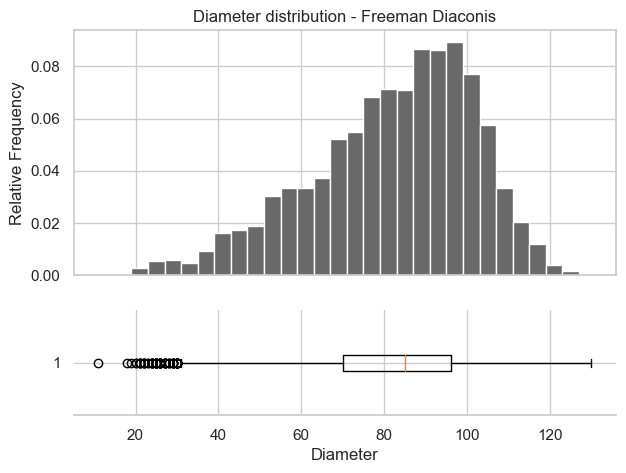

In [17]:
diameter_bins = histogram_w_whiskers(df, "Diameter")

As we predicted, the diameter distribution looks almost identical to the length distribution. 

Now we use the $histogram\_trio()$ method to chart three different histograms, each with a different number of bins.

Freeman Diaconis for Diameter: 30 bins


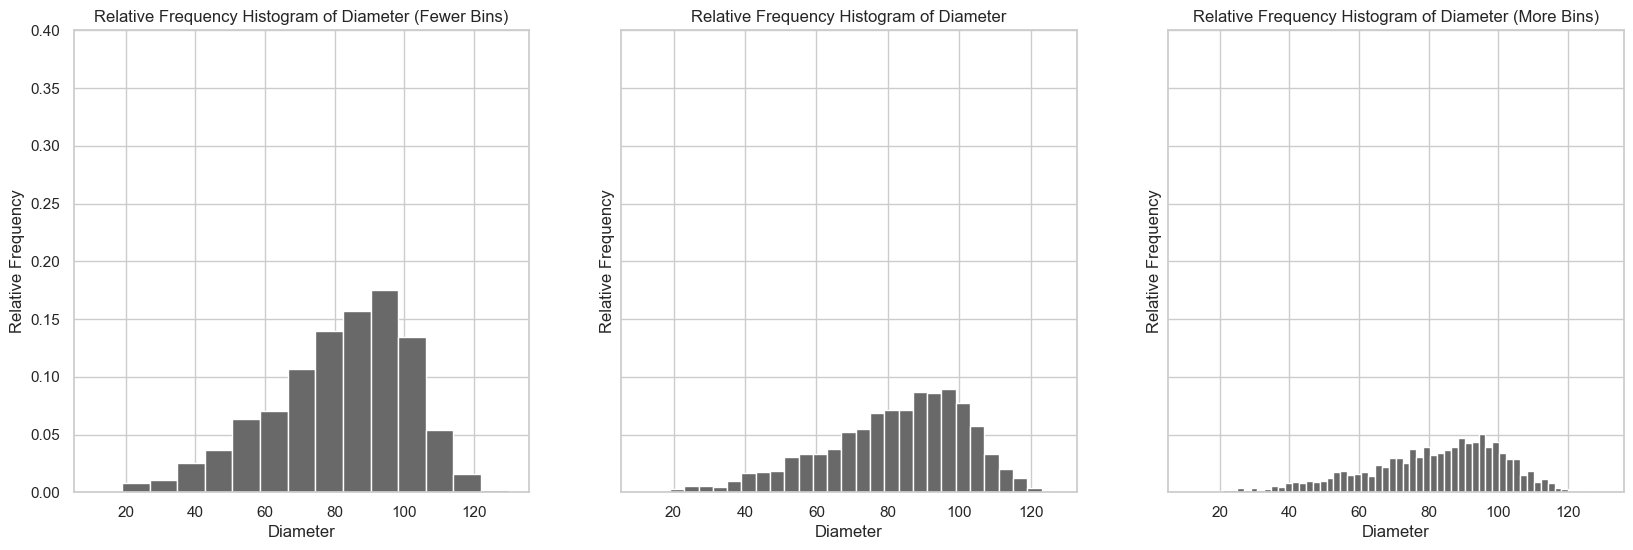

In [18]:
histogram_trio(df, "Diameter", zoom=0.4)

After using different numbers of bins, we see that the overall shape of the data remains consistent, and it still appears to follow a similar shape to the length charts.

In summary, we found that abalone diameters range from 11 to 130 millimeters, with the average being 82 mm.

<a id="Height"></a>
## Height

The height variable is the measurement of the abalone with the meat still in the shell. It is a continuous numerical variable measured in millimeters.

**Domain Knowledge**

We use the same domain knowledge as we obtained for the abalone length and diameter variables.

After looking at images of abalone, it can be observed that the meat of the abalone stick out from the bottom of the shell somewhat, meaning that the height measurement is the measurement from the bottom of the meat to the top of the shell.

**Hypothesis**

We predict that the abalone heights will also follow the same approximate distribution as the length variable, and that height, diameter and length are all directly related. We also predict that the heights will be shorter than the lengths and the diameters.

First we start out using the describe() method to get some preliminary summary statistics of our data.

In [19]:
df.Height.describe()

count    4176.000000
mean       27.905412
std         8.365278
min         0.000000
25%        23.000000
50%        28.000000
75%        33.000000
max       226.000000
Name: Height, dtype: float64

The summary statistics support our hypothesis. The mean is 28 which is indeed shorter than the average diameter value of 82.

However, the preliminary descriptive statistics seem to include some extreme and potentially erroneous values. The minimum height is 0.00, which cannot be possible. The max is also 226.00 mm (8.9 inches), which is possible, but is certainly an extreme value. This value is likely erroneous as well, since we would have expected to see a similarly extreme value of length and diameter to match.

Now we use a histogram using Freeman Diaconis bins as well as a box-and-whiskers plot. These charts will allow us to see the distribution better. We expect to see a distribution with some large extreme values.

Freeman Diaconis for Height: 113 bins


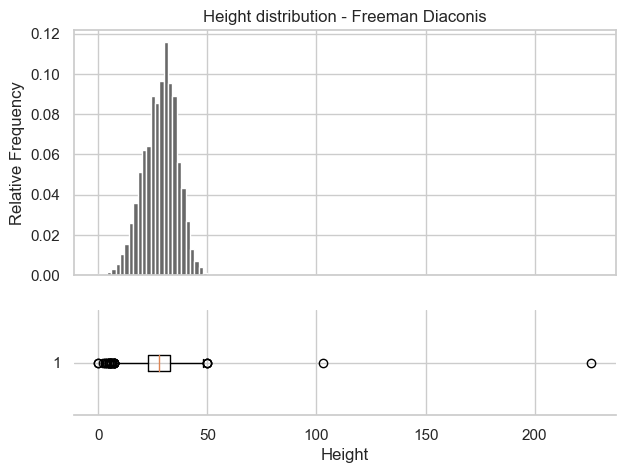

In [20]:
diameter_bins = histogram_w_whiskers(df, "Height")

As we predicted, the height distribution looks very similar to the length and diameter distributions. However, we do see the extreme values here. There is a height just above 100 mm, as well as the 226 mm maximum value. 

To get better histograms, we can remove these extreme values.

In [21]:
outlier_mask = df['Height'] == 0
df = df[~outlier_mask]
outlier_mask = df['Height'] == 103
df = df[~outlier_mask]
outlier_mask = df['Height'] == 226
df = df[~outlier_mask]

df.describe()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
count,4172.000000,4172.000000,4172.000000,4172.000000,4172.000000,4172.000000,4172.000000,4172.000000
mean,104.810882,81.585091,27.853308,165.761074,71.867210,36.122795,47.762967,9.934324
std,24.014050,19.844026,7.675201,98.004299,44.344303,21.906201,27.836310,3.224294
min,15.000000,11.000000,2.000000,0.400000,0.200000,0.100000,0.300000,1.000000
25%,90.000000,70.000000,23.000000,88.375000,37.200000,18.700000,26.000000,8.000000
50%,109.000000,85.000000,28.000000,160.000000,67.200000,34.200000,46.800000,9.000000
75%,123.000000,96.000000,33.000000,230.650000,100.400000,50.600000,65.725000,11.000000
max,163.000000,130.000000,50.000000,565.100000,297.600000,152.000000,201.000000,29.000000


We can see that we've removed the extreme values from the data. Now we can try the histogram again.

Freeman Diaconis for Height: 24 bins


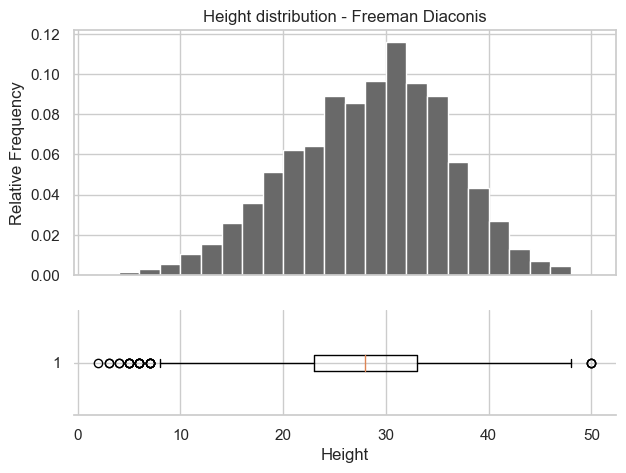

In [22]:
diameter_bins = histogram_w_whiskers(df, "Height")

The histogram is much better now. Now we use the $histogram\_trio()$ method to chart three different histograms, each with a different number of bins.

Freeman Diaconis for Height: 24 bins


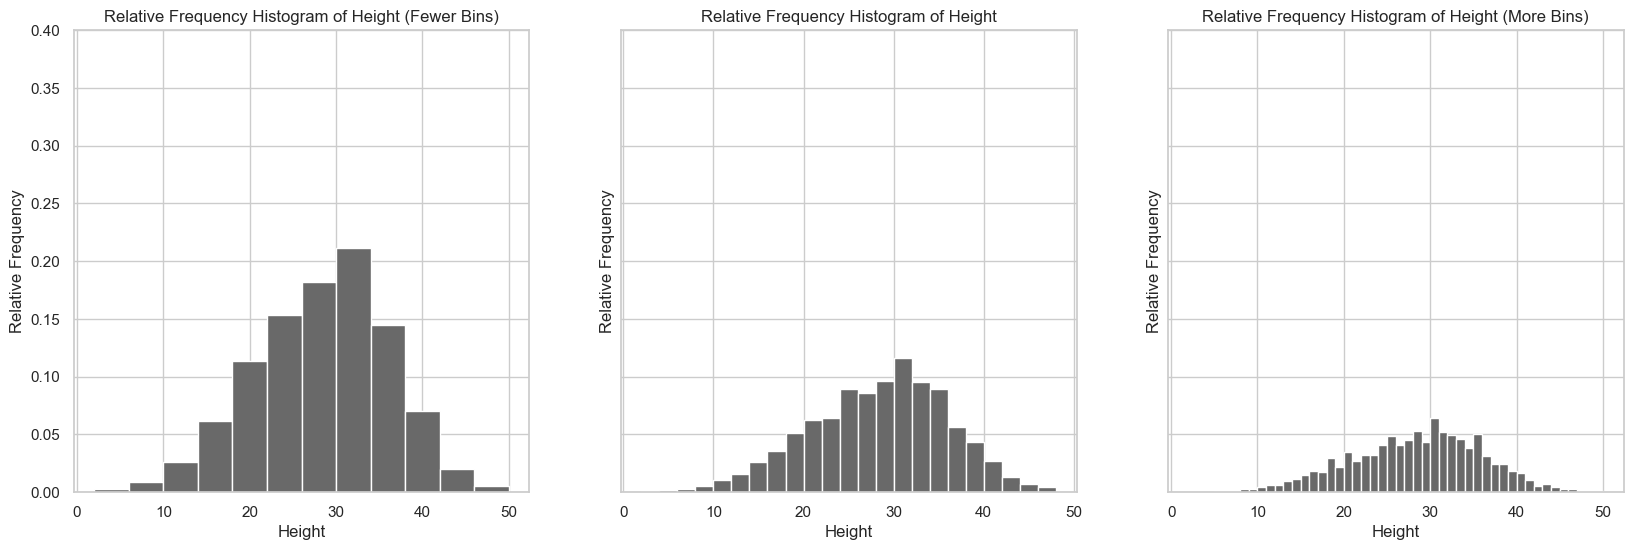

In [23]:
histogram_trio(df, "Height", zoom=0.4)

After using different numbers of bins, we see that the overall shape of the data remains consistent, and it still appears to follow a similar shape to the length and diameter charts.

In summary, we found that abalone heights range from 2 to 50 mm, with an average of 28 mm. We also found that the height measurement seems to be directly related to the length and diameter measurements.

<a id="Whole weight"></a>
## Whole weight

The Whole Weight variable is the weight of the whole abalone, including the shell and the meat. It is a continuous numerical variable measured in grams.

**Domain Knowledge**

Live abalone range from 250 - 350 grams when fully grown.

Data Source: [sydneyfishmarket.com](https://www.sydneyfishmarket.com.au/Home/Seafood/Species-Information/List/Blacklip-Abalone#:~:text=Live%20Abalone%20is%20250g%2D350g,the%20shell%20measuring%2013%2D17cm.&text=One%20of%20Australia's%20most%20highly,for%20around%20A%24100%2Fkg.)
Retrieved on October 16, 2023.


**Hypothesis**

We predict that the abalone weights range from a low value of about 1 gram all the way up to 350 grams or a little lower. We also predict that the weight distribution will look similar to the length measurements.

First we start out using the describe() method to get some preliminary summary statistics of our data.

In [24]:
df.Whole_weight.describe()

count    4172.000000
mean      165.761074
std        98.004299
min         0.400000
25%        88.375000
50%       160.000000
75%       230.650000
max       565.100000
Name: Whole_weight, dtype: float64

The summary statistics show that the whole abalone weights exceed our hypothesis. The minimum whole weight is 0.4 grams, and the maxium is 565 grams. It is difficult to tell whether these are extreme or erroneous weights. We can use a histogram to see if this may be the case.

Now we use a histogram using Freeman Diaconis bins as well as a box-and-whiskers plot. These charts will allow us to see the distribution better. We expect to see a distribution with some large extreme values.

Freeman Diaconis for Whole_weight: 32 bins


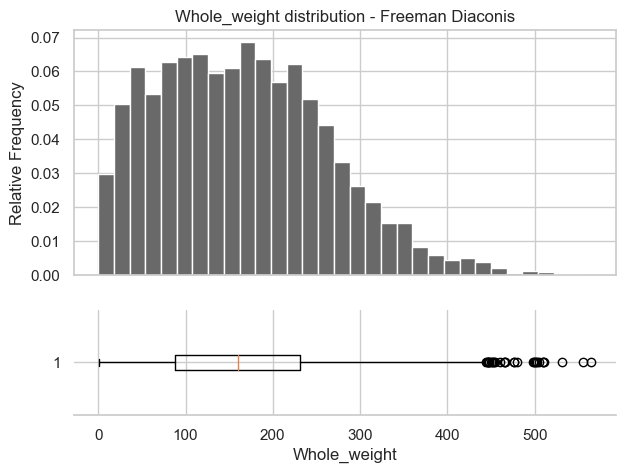

In [25]:
Whole_weight_bins = histogram_w_whiskers(df, "Whole_weight")

It does not appear that there are extreme/erroneous values in the weight data. This may be because we eliminated the erroneous data rows in a previous step.

We notice that this whole weight distribution is not the same as the length variables' distributions. Instead, the whole weight data is shifted to the left, and has a trailing end to the right with extreme values. This is likely becuase the length grows quickly at first but slowly later, whereas the weight grows at a more steady rate independent of the shell growth. Thus, the weight distribution roughly follows the age distribution (the rings distribution). Most abalone that are found are younger/middle aged, whereas older abalone are more rare.

Now we use the $histogram\_trio()$ method to chart three different histograms, each with a different number of bins.

Freeman Diaconis for Whole_weight: 32 bins


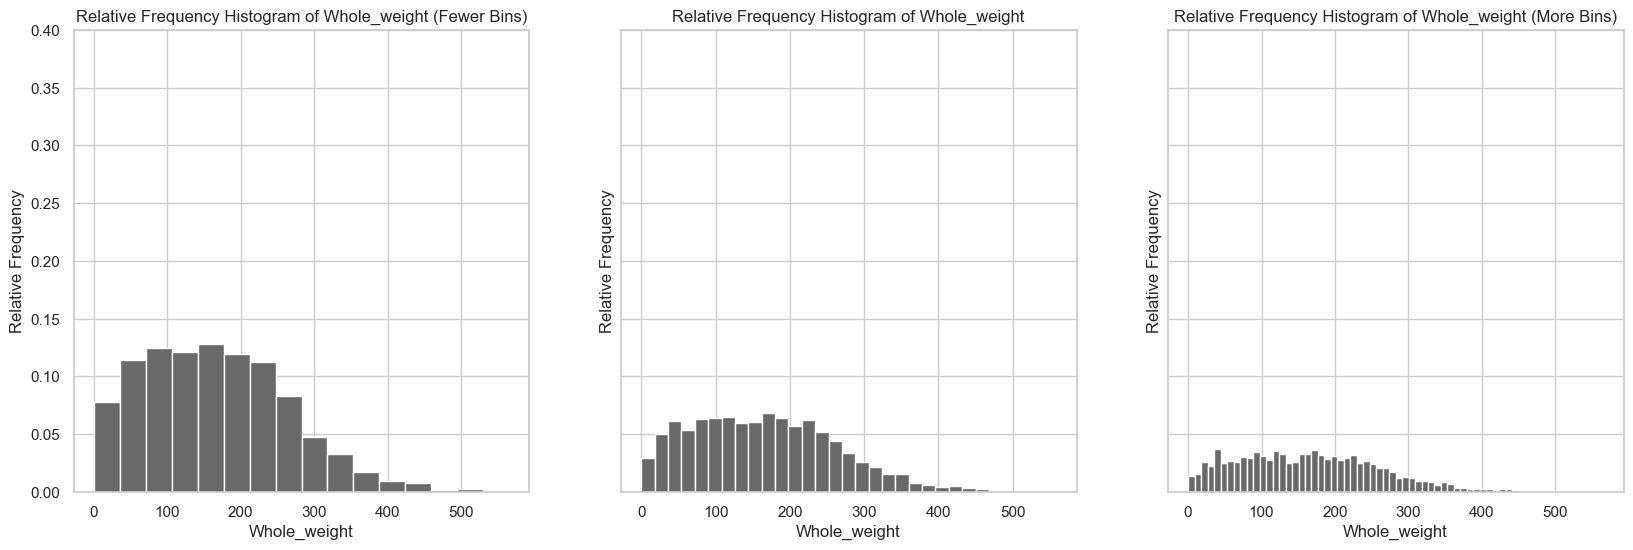

In [26]:
histogram_trio(df, "Whole_weight", zoom=0.4)

After using different numbers of bins, we see that the overall shape of the data remains consistent, and it still appears to follow a similar shape to the rings charts.

In summary, we found that abalone weights range from 0.4 grams to 565 grams. We also found that the abalone weight does not follow the same distribution as the shell lengths. Instead, the whole weight variable more closely follows the Rings variable. 

<a id="Shucked weight"></a>
## Shucked weight

Shucked Weight is a continuous numerical variable that is measured in grams. 

**Domain Knowledge**

Shucking is the process of removing the shells from shellfish. The Shucked Weight represents the weight of the meat after being removed from the shell.

**Hypothesis**

We predict that the Shucked weight variable will follow the same distribution as the whole weight variable. We predict that the shucked weights will be somewhat smaller than the whole weights, since the shells have been removed.

First we start out using the describe() method to get some preliminary summary statistics of our data.

In [27]:
df.Shucked_weight.describe()

count    4172.000000
mean       71.867210
std        44.344303
min         0.200000
25%        37.200000
50%        67.200000
75%       100.400000
max       297.600000
Name: Shucked_weight, dtype: float64

The summary statistics support our hypothesis. The shucked weights are less than the whole weights. The mean shucked weight is 72 grams whereas the mean whole weight is 166 grams.

Now we use a histogram using Freeman Diaconis bins as well as a box-and-whiskers plot. These charts will allow us to see the distribution better. We expect to see a distribution similar to the whole weight distribution.

Freeman Diaconis for Shucked_weight: 38 bins


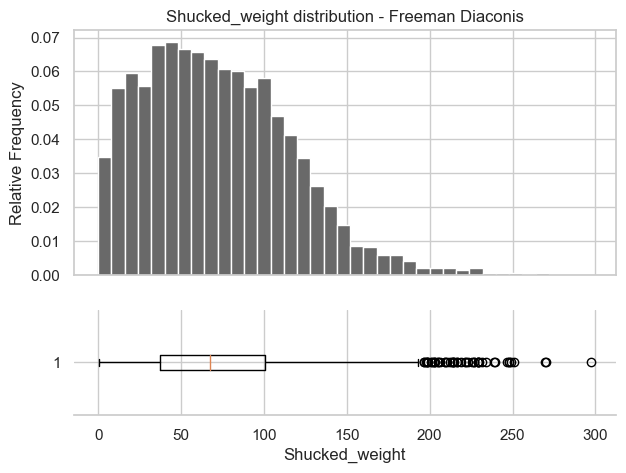

In [28]:
Shucked_weight_bins = histogram_w_whiskers(df, "Shucked_weight")

As we expected, the distribution of the shucked weight looks quite similar to the distribution of the whole weight. This is because shucked weight and whole weight are directly related.

Now we use the $histogram\_trio()$ method to chart three different histograms, each with a different number of bins.

In [ ]:
histogram_trio(df, "Shucked_weight", zoom=0.4)

Freeman Diaconis for Shucked_weight: 38 bins


After using different numbers of bins, we see that the overall shape of the data remains consistent, and it still appears to follow a similar shape to the whole weight chart.

In summary, we found that abalone shucked weights range from 0.2 grams to 298 grams. We also found that the shucked weight closely follows the distribution of the whole weight.

<a id="Viscera weight"></a>
## Viscera weight

Viscera weight is a continuous numerical variable measured in grams.

**Domain Knowledge**

As abalone are harvested, their guts are removed to leave only the meat. The guts are measured after bleeding.

**Hypothesis**

We predict that the viscera weight will be less than both the whole weight and the shucked weight, and will follow the same distribution as both.

First we start out using the describe() method to get some preliminary summary statistics of our data.

In [ ]:
df.Viscera_weight.describe()

The summary statistics support our hypothesis. The viscera weights are less than the whole and shucked weights. The mean viscera weight is 36 grams whereas the mean whole weight is 166 grams and the mean shucked weight is 72 grams.

Now we use a histogram using Freeman Diaconis bins as well as a box-and-whiskers plot. These charts will allow us to see the distribution better. We expect to see a distribution similar to the whole weight distribution.

In [ ]:
Viscera_weight_bins = histogram_w_whiskers(df, "Viscera_weight")

As we expected, the distribution of the viscera weight looks similar to the distributions of both whole weight and shucked weight. This is because abalone with heavy weights are more likely to also have heavy guts. In other words, they are all directly related.

Now we use the $histogram\_trio()$ method to chart three different histograms, each with a different number of bins.

In [ ]:
histogram_trio(df, "Viscera_weight", zoom=0.4)

After using different numbers of bins, we see that the overall shape of the data remains consistent, and it still appears to follow a similar shape to the whole weight and shucked weight charts.

In summary, we found that abalone viscera weights range from 0.1 grams to 152 grams. We also found that the viscera weight closely follows the distribution of the whole weight and shucked weight.

<a id="Shell weight"></a>
## Shell weight

Shell weight is a continuous numerical variable measured in grams.

**Domain Knowledge**

Abalone shells are valuable because of their highly desirable iridescent shells. Abalone shells look regular from the outside, but on the inside they contain a thick layer of iridescent mother-of-pearl that lends itself for use in home decor and jewelry.

Data Source: [treehugger.com](https://www.treehugger.com/abalone-facts-5180643#:~:text=They%20Have%20Highly%20Desirable%20Iridescent%20Shells&text=While%20they%20may%20look%20unexciting,into%20home%20decor%20and%20jewelry.)
Retrieved on October 16, 2023.

**Hypothesis**

We predict that the shell weight will be less than the whole weight, and that it will follow a distribution more similar to the length variable than the whole weight variable.

First we start out using the describe() method to get some preliminary summary statistics of our data.

In [ ]:
df.Shell_weight.describe()

The summary statistics support part of our hypothesis. The shell weights are indeed less than the whole weights. The mean shell weight is 48 grams whereas the mean whole weight is 166.

Now we use a histogram using Freeman Diaconis bins as well as a box-and-whiskers plot. These charts will allow us to see the distribution better. We expect to see a distribution similar to the length variable distributions.

In [ ]:
Shell_weight_bins = histogram_w_whiskers(df, "Shell_weight")

Interestingly, our hypothesis does not seem to be supported by the data. The shell weight distribution seems very similar to the various weight variables, but we predicted that the shell weight distribution would look similar to the length distributions. It would appear that shell weight also increases steadily throughout an abalone's life, but the shell size increases quickly at first and then gradually as it gets older.

Now we use the $histogram\_trio()$ method to chart three different histograms, each with a different number of bins.

In [ ]:
histogram_trio(df, "Viscera_weight", zoom=0.4)

After using different numbers of bins, we see that the overall shape of the data remains consistent, and it still appears to follow a similar shape to the whole weight and shucked weight charts.

In summary, we found that abalone shell weights range from 0.3 grams to 201 grams. We also found that the shell weights data follows a similar distribution to the whole weight distribution.

In [ ]:
def describe_by_category(data, numeric, categorical, transpose=False):
    grouped = data.groupby(categorical)
    grouped_y = grouped[numeric].describe()
    if transpose:
        print(grouped_y.transpose())
    else:
        print(grouped_y)

In [ ]:
def lowess_scatter(data, x, y, jitter=0.0, skip_lowess=False):
    
    if skip_lowess:
        fit = np.polyfit(data[x], data[y], 1)
        line_x = np.linspace(data[x].min(), data[x].max(), 10)
        line = np.poly1d(fit)
        line_y = list(map(line, line_x))
    else:
        lowess = sm.nonparametric.lowess(data[y], data[x], frac=.3)
        line_x = list(zip(*lowess))[0]
        line_y = list(zip(*lowess))[1]
    
    figure = plt.figure(figsize=(10, 6))
    
    axes = figure.add_subplot(1, 1, 1)
    
    xs = data[x]
    if jitter > 0.0:
        xs = data[x] + stats.norm.rvs( 0, 0.5, data[x].size)
    
    axes.scatter(xs, data[y], marker="o", color="DimGray", alpha=0.5)
    axes.plot(line_x, line_y, color="DarkRed")
    
    title = "Plot of {0} v. {1}".format(x, y)
    if not skip_lowess:
        title += " with LOWESS"
    axes.set_title(title)
    axes.set_xlabel(x)
    axes.set_ylabel(y)
    
    plt.show()
    plt.close()

## Pairwise EDA

Now that we have looked at each variable individually, we will look at pairs of variable. More specifically, we will be looking at each of the variables paired with our target variable, **Rings**. Our goal is to see how each of the variables affects the number of rings on an abalone shell.

<a href="#Rings vs Sex">Rings vs Sex</a><br>
<a href="#Rings vs Length">Rings vs Length</a><br>
<a href="#Rings vs Diameter">Rings vs Diameter</a><br>
<a href="#Rings vs Height">Rings vs Height</a><br>
<a href="#Rings vs Whole weight">Rings vs Whole weight</a><br>
<a href="#Rings vs Shucked weight">Rings vs Shucked weight</a><br>
<a href="#Rings vs Viscera weight">Rings vs Viscera weight</a><br>
<a href="#Rings vs Shell weight">Rings vs Shell weight</a>

<a id="Rings vs Sex"></a>
## Rings vs Sex

It is possible that Rings and Sex have somewhat of a correlation, but we guess that it is not strong. When we looked at the data, we saw that there are slightly more male abalone than female abalone. If this trend is caused by male abalone living longer than female abalone, then we may see some sort of a correlation.

Here are the summary statistics for Rings, grouped by Sex.

In [ ]:
describe_by_category(df, "Rings", "Sex", transpose=True)

There does not seem to be a large difference between male and female rings. The mean ring count for males is 10.7 and the mean ring count for females is 11.1. However, there is a difference when compared to infants. Infants have a mean ring count of only 7.9, which is definitely less than both males and females. This result should come as no surprise, as infants have not had as much time on average to grow higher numbers of rings.

Now let's make histograms for each sex so that they may be compared.

In [ ]:
grouped = df.groupby("Sex")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 3, 1)

observations = len(grouped["Rings"].get_group("M"))
empirical_weights = np.ones(observations)/observations # this converts counts to relative frequencies when used in hist()

axes.hist(grouped["Rings"].get_group("M"),bins=20,color="dimgray", weights=empirical_weights)
axes.set_title("Male Rings distribution - Freeman Diaconis")
axes.set_xlabel("Rings")
axes.set_ylim((0,.6))
axes.set_ylabel("Relative Frequency")

observations = len(grouped["Rings"].get_group("F"))
empirical_weights = np.ones(observations)/observations # this converts counts to relative frequencies when used in hist()

axes = figure.add_subplot(1, 3, 2)
axes.hist(grouped["Rings"].get_group("F"),bins=20,color="dimgray", weights=empirical_weights)
axes.set_title("Female Rings distribution - Freeman Diaconis")
axes.set_xlabel("Rings")
axes.set_ylim((0,.6))

observations = len(grouped["Rings"].get_group("I"))
empirical_weights = np.ones(observations)/observations # this converts counts to relative frequencies when used in hist()

axes = figure.add_subplot(1, 3, 3)
axes.hist(grouped["Rings"].get_group("I"),bins=20,color="dimgray", weights=empirical_weights)
axes.set_title("Infant Rings distribution - Freeman Diaconis")
axes.set_xlabel("Rings")
axes.set_ylim((0,.6))

plt.show()
plt.close()

We can see more clearly how infants have fewer rings on average than both males and females. Males and females follow roughly the same distribution as well. Females have a spike right around 9 rings, whereas males have a spike at 12 but a sharp dropoff after that. 

<a id="Rings vs Length"></a>
## Rings vs Length

We expect that length has some effect on rings but the effect is somewhat limited. During our single variable EDA we observed that the rings distribution was concentrated to the left but the length distribution was concentrated to the right, so we don't expect the correlation to be perfect.


Here are the correlation coefficients:

In [ ]:
print("r   = ", stats.pearsonr(df.Rings, df.Length)[0])
print("rho = ", stats.spearmanr(df.Rings, df.Length)[0])

Pearson's correlation coefficient, $r$, is 0.56 which indicates a moderate positive relationship. This finding supports our hypothesis that length and rings are somewhat correlated but not strongly. Spearman's is also at 0.60, indicating a moderate positive relationship as well. 

Here's a scatter plot of the variables with a LOWESS line.

In [ ]:
lowess_scatter(df, "Length", "Rings", jitter=0, skip_lowess=False)

We can see that as length increases, so to do the number of Rings. However, the shape of the scatter plot is odd. 

Let's try flipping the axes and adding some jitter.

In [ ]:
lowess_scatter(df, "Rings", "Length", jitter=.1, skip_lowess=False)

Charting this data in this orientation highlights some very interesting findings. Because we know that an abalone creates a new ring every year, the x-axis can be thought of as the age of the abalone. We see that in the first 10 years of the abalone's life, it's length increases very quickly. But after 10 years, it's length increases slowly but at a steady rate. This is consistent with the domain knowledge we gathered when performing single-variable EDA for the length variable that said that abalone grow quickly for the first few years of their life, and then grows very slowly for the remainder. This chart clearly shows the relationship between length and rings for abalone.

<a id="Rings vs Diameter"></a>
## Rings vs Diameter

We expect that diameter also has some effect on the number of rings on an abalone shell. We predict that diameter has a very similar effect on rings as the length variable, since we found during single-variable EDA that length and diameter have very similar distributions.

In [ ]:
print("r   = ", stats.pearsonr(df.Rings, df.Diameter)[0])
print("rho = ", stats.spearmanr(df.Rings, df.Diameter)[0])

Pearson's correlation coefficient, $r$, is 0.57 which indicates a moderate positive relationship. This finding supports our hypothesis that diameter and rings are somewhat correlated but not strongly. Spearman's is also at 0.62, indicating a moderate positive relationship as well. These correlation coefficients are slightly stronger but very similar to the coefficients for length vs. rings, which is in line with our expectation.

Here's a scatter plot of the variables with a LOWESS line.

In [ ]:
lowess_scatter(df, "Diameter", "Rings", jitter=0, skip_lowess=False)

Once again, we see the number of rings increase with diameter, similar to length. But the plot seems to tell us more.

Let's try flipping the axes again and adding some jitter.

In [ ]:
lowess_scatter(df, "Rings", "Diameter", jitter=.1, skip_lowess=False)

We observe the same pattern that we saw with length; diameter increases quickly from years 0 to 10, and then increases very slowly from 10 years on. 

<a id="Rings vs Height"></a>
## Rings vs Height

Because we observed length, diameter and height having very similar distributions, it follows that height has a similar relationship with rings as length and diameter. We expect height to increase quickly from years 0 to 10, and then increase slowly from years 10 and on.

First we calculate the correlation coefficients.

In [ ]:
print("r   = ", stats.pearsonr(df.Rings, df.Height)[0])
print("rho = ", stats.spearmanr(df.Rings, df.Height)[0])

Pearson's correlation coefficient, $r$, is 0.61 which indicates a moderate positive relationship. This finding supports our hypothesis that diameter and rings are somewhat correlated but not strongly. Spearman's is also at 0.66, indicating a moderate positive relationship as well. These correlation coefficients are once again slightly stronger but very similar to the coefficients for length vs. rings and diameter vs rings, which is in line with our expectation.

Here's a scatter plot of the variables with a LOWESS line.

In [ ]:
lowess_scatter(df, "Height", "Rings", jitter=0.1, skip_lowess=False)

Once again, we see the number of rings increase with height, similar to length and diameter. But the plot seems to tell us more.

Let's try flipping the axes again and adding some jitter.

In [ ]:
lowess_scatter(df, "Rings", "Height", jitter=.1, skip_lowess=False)

We observe the same pattern that we saw with both length and diameter; height increases quickly from years 0 to 10, and then increases very slowly from 10 years on. 

It would appear that length, diameter and height all have the same relationship with rings. This makes sense, because we observed during single variable EDA that all three of these length measurements follow the same distribution, and our domain knowledge tells us that they should all be very closely related. We observe that as the number of rings increase, all three of the length variables increase quickly from years 0 to 10, and then increase slowly from 10 years on.

<a id="Rings vs Whole weight"></a>
## Rings vs Whole weight

Whole weight is our first weight measurement. We observed during single variable EDA that weight did not follow the same distribution as the length measurements. The length measurements had data values concentrated to the right of the histogram, which we conclude from domain knowledge is due to the fact that shells grow quickly at first and then slowly later on in life. But the weight measurement seems to follow a different distribution where values are concentrated to the left, which we assume means that abalone weight increases at a more constant rate than the shells. Thus, because both rings and weights should be increasing at constant rates, we assume higher correlations between the weight measurements and the number of rings on abalone shells.

First we calculate the correlation coefficients.

In [ ]:
print("r   = ", stats.pearsonr(df.Rings, df.Whole_weight)[0])
print("rho = ", stats.spearmanr(df.Rings, df.Whole_weight)[0])

Pearson's correlation coefficient, $r$, is 0.54 which indicates a moderate positive relationship. Spearman's is also at 0.63, indicating a moderate positive relationship as well. These findings do not fully support our hypothesis. These correlation coefficients are very similar to those of the length measurements, but we predicted that they would be greater than the length measurements.

Let's try a scatter plot to get a better idea of what is going on.

In [ ]:
lowess_scatter(df, "Whole_weight", "Rings", jitter=0.1, skip_lowess=False)

The chart tells an interesting story. It appears that weight does not increase linearly with rings like we expected. It seems to increase in a different fashion. We observe that as whole weight increases, rings increases quickly at first, and the slowly as whole weight increases.

Let's try flipping the axes and adding some jitter to get a better understanding.

In [ ]:
lowess_scatter(df, "Rings", "Whole_weight", jitter=0.1, skip_lowess=False)

Surprisingly, we observe a somewhat similar LOWESS line to the length measurements. The whole_weight increases quickly from 0 to 10 rings, and then increases slowly from 10 rings on. 

However, there is a noticeable difference here as well. Instead of increasing linearly from ages 0 to 10, the whole_weight variable seems to increase relatively slowly at first, and then quickly from age 6 to 10. It almost seems to increase quadratically from years 0 to 10. This would be more consistent with our first scatter plot, which shows clear non-linear behavior. 

It would seem as though abalone whole_weight increases slowly at first, then at the 6 year mark whole_weight increases quickly until about year 11, where it then slows down.

<a id="Rings vs Shucked weight"></a>
## Rings vs Shucked weight

We expect shucked weight to have the same effect on the number of rings as the whole weight, since we observed during our single-variable EDA that all four of the weight measurements follow the same distribution. Thus, we expect rings to be moderately correlated with shucked weight. We also expect shucked weight to increase quickly from ages 0 to 10, and slowly from ages 10 and on.

First we calculate the correlation coefficients.

In [ ]:
print("r   = ", stats.pearsonr(df.Rings, df.Shucked_weight)[0])
print("rho = ", stats.spearmanr(df.Rings, df.Shucked_weight)[0])

Pearson's correlation coefficient, $r$, is 0.42 which indicates a low positive relationship. Spearman's is also at 0.54, indicating a moderate positive relationship. These correlation coefficients partially support our hypothesis. On the one hand, they are relatively similar to the whole weight, but on the other, the Pearson's $r$ value decreased from 0.54 to 0.42, and fell into the 'low' correlation tier. It is hard to tell if this different is significant until we see it visually.

Let's try a scatter plot to get a better idea of what is going on.

In [ ]:
lowess_scatter(df, "Shucked_weight", "Rings", jitter=0.1, skip_lowess=False)

After charting the shucked weight against the number of rings, it does seem to follow a very similar distribution as the whole weight.

Let's try flipping the axes and adding some jitter again.

In [ ]:
lowess_scatter(df, "Rings", "Shucked_weight", jitter=0.1, skip_lowess=False)

Again, the shucked weight vs rings chart looks very similar to the whole weight vs rings chart. This result is what we expected after seeing the similar distributions of the weight variables during single variable EDA.

It would seem as though abalone shucked_weight increases slowly at first, then at the 6 year mark shucked_weight increases quickly until about year 11, where it then slows down.

<a id="Rings vs Viscera weight"></a>
## Rings vs Viscera weight

Like the previous two weight measurements, we expect viscera weight to increase quickly at first, and then slowly after 10 rings.

First we calculate the correlation coefficients.

In [ ]:
print("r   = ", stats.pearsonr(df.Rings, df.Viscera_weight)[0])
print("rho = ", stats.spearmanr(df.Rings, df.Viscera_weight)[0])

Pearson's correlation coefficient, $r$, is back up to 0.50 which indicates a moderate positive relationship. Spearman's is also at 0.61, indicating a moderate positive relationship. These correlation coefficients support our hypothesis. They both indicate a moderate correlation between viscera weight and rings. They are also similar to the previous two weight measurements.

Let's try a scatter plot to get a better idea of what is going on.

In [ ]:
lowess_scatter(df, "Viscera_weight", "Rings", jitter=0.1, skip_lowess=False)

After charting the shucked weight against the number of rings, it does seem to follow a very similar distribution as both the whole weight and the shucked weight. The chart almost looks identical to those two. 

Let's try flipping the axes and adding some jitter again.

In [ ]:
lowess_scatter(df, "Rings", "Viscera_weight", jitter=0.1, skip_lowess=False)

As we expected, the viscera weight vs rings chart looks very similar to the shucked weight and whole weight charts. 

It would seem as though abalone viscera_weight increases slowly at first, then at the 6 year mark viscera_weight increases quickly until about year 11, where it then slows down.

<a id="Rings vs Shell weight"></a>
## Rings vs Shell weight

Once again, we expect shell weight to have a similar correlation with rings as the previous weight measurements. We expect that as rings increase, shell weight will increase slowly from years 0 to 6, then quickly until year 11, and then slowly from then on.

First we calculate the correlation coefficients.

In [ ]:
print("r   = ", stats.pearsonr(df.Rings, df.Shell_weight)[0])
print("rho = ", stats.spearmanr(df.Rings, df.Shell_weight)[0])

Pearson's correlation coefficient, $r$, is 0.63 which indicates a moderate positive relationship. Spearman's is also at 0.69, indicating a moderate positive relationship. These correlation coefficients support our hypothesis. They are similar to the correlation coefficients we calculated for the previous three weight variables.

Interestingly, although these values are similar, they are noticeably stronger than the previous coefficients. The Pearson's $r$ coefficient increased from 0.50, 0.42 and 0.54 in the previous three weight measurements up to 0.63 for shell weight vs rings. Spearman's rho increased from 0.61, 0.54 and 0.63 up to 0.69 as well, almost putting it into the 'strong' correlation tier. 

This result makes sense, as we would expect the number of rings to be more closely correlated with shell weight than any of the other weight measurements, as shell rings likely directly add to shell weight. 

Let's try a scatter plot to see if we can visualize this stronger correlation.

In [ ]:
lowess_scatter(df, "Shell_weight", "Rings", jitter=0.1, skip_lowess=False)

After charting the shell weight against the number of rings, it does seem to follow a very similar distribution as the other weight variables.

Let's try flipping the axes and adding some jitter again.

In [ ]:
lowess_scatter(df, "Rings", "Shell_weight", jitter=0.1, skip_lowess=False)

Again, the shell weight vs rings chart looks very similar to the other weight measurements. It is difficult to see the stronger correlation we observed with the correlation coefficients. 

We can say that abalone shell_weight increases slowly at first, then at the 6 year mark whole_weight increases quickly until about year 11, where it then slows down again.

## 3 <a id="step3">Statistical and Mathematical Modeling of the Target Variable</a>
<a href="#Predictive Model">Predictive Model</a><br>
<a href="#Data Generating Story">Data Generating Story</a><br>
<a href="#Distribution Model">Distribution Model</a><br>
<a href="#Question 1">Question 1</a><br>
<a href="#Question 2">Question 2</a><br>
<a href="#Question 3">Question 3</a>

<a id="Predictive Model"></a>
## Predictive Model

We create a mean model to serve as a constant model. In other words, if we were to pull a random abalone out of the ocean, what single value would we predict to be it's number of rings?

To create our mean model, we first define our loss function. We intend for overestimates and underestimates to be treated symmetrically, and for large errors to be given more weight than small errors. Thus, we choose our loss function to be Mean Squared Error. Because we have chosen Mean Squared Error to be our loss function, and the constant model that will minimize MSE is the mean, we choose the mean as our constant model.

To create a mean model for our abalone data, we can take the mean value generated from our descriptive statistics above for the rings variable. We can recalculate the mean as follows.

In [ ]:
abalone_predict = np.mean(df.Rings)
print(abalone_predict)

We find that the mean abalone rings of our data is 9.93. As a predictive model, we can say that the length of a random abalone pulled from the ocean will have about 9.93 rings.

In order to provide error bounds on our prediction, we have two options. If the data is approximately normally distributed, we can put bounds on our error of 1.96 standard deviations from the mean. If they are not, we can use Chebyshev's inequality, which states that $1 - \frac{1}{k^2}$ percent of the data must be within $k$ standard deviations from the mean. 

Since the data seems to be approximately normally distributed (not necessarily actually normally distributed), we will use 1.96 standard deviations from the mean as our error bounds. 

We recalculate the standard deviation of the data as follows.

In [ ]:
abalone_std = np.std(df.Rings)
print(abalone_std)

We find that the standard deviation of our data is 3.22.

Now we can calculate our error bounds.

In [ ]:
abalone_error = abalone_std * 1.96
print(abalone_error)

abalone_predict, abalone_predict - abalone_error, abalone_predict + abalone_error

Thus, we can say that our mean model predicts that a random abalone will have 9.93 rings, with a 95% chance of it having between 3.62 and 16.25 rings.

<a id="Data Generating Story"></a>
## Data Generating Story

Because the number of rings on an abalone shell roughly equates to the number of years it has been alive, the data generating story for abalone shell rings is roughly the same as the data generating story for the age of abalone. Abalone are born, and must eat to survive. How long an abalone lives (and therefore how many rings it has) is determined by many different factors, including location in the ocean, genetics, food supply and water quality. Thus, it is likely that the number of rings on an abalone shell is determined by many small effects working over time. We predict that the rings variable approximately follows a normal distribution. If a normal distribution is not a good fit, we will also try a log-normal distribution, which we suspect may also be a good fit since the data is right-skewed.

<a id="Distribution Model"></a>
## Distributional Model

We want to be able to answer questions such as "what is the percent chance that an abalone has more than 12 rings?". These types of questions go beyond the capabilities of the null predictor we calculated above. In order to be able to answer these more complex questions, we want to find a mathematical distribution that approximates our data as closely as possible. 

The normal distribution has two parameters, which happen to be the first and second moments of the empirical distribution. These are the mean and standard devation of the empirical data, which we have already calculated.

We start by plotting the normal distribution with these parameters over the empirical distribution to check the fit.

In [ ]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)
n, bins, patches = axes.hist(df.Rings, color="DimGray", density=True, bins=30, alpha=0.75)
axes.set_xlabel( "Rings")
axes.set_ylabel( "Density")
axes.set_title("Density Histogram of Abalone Rings with Normal plot")

xs = [(b2 + b1)/2 for b1, b2 in zip(bins, bins[1:])]    

abalone_mean = np.mean(df.Rings)
abalone_std  = np.std(df.Rings)
ys = [norm.pdf( k, loc=abalone_mean, scale=abalone_std) for k in xs]
axes.plot(xs, ys, color="darkred")

plt.show()
plt.close()

After plotting the normal distribution over the empirical distribution, it appears as though the normal distribution is not a great fit for the data. We see that it overpredicts at the low end, then underpredicts in the mid-range, and then overpredicts between 11 and 15, then underpredicts again for the trailing end to the right. We will need to try a different distribution to get a better fit. 

Let's try a log-gaussian distribution. We know that if $X$ follows a log-gaussian distribution, then $Y = ln(X)$ will follow a gaussian distribution. Thus, to see if our data can be closely modeled by a log-gaussian distribution, we take it's natural log and plot it against a regular gaussian distribution using the moments derived from the natural log data $(Y)$.

In [ ]:
df['log_Rings'] = df['Rings'].apply(lambda x: np.log(x))

figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)
n, bins, patches = axes.hist(df['log_Rings'], color="DimGray", density=True, bins=30)
axes.set_xlabel("log(Rings)")
axes.set_ylabel("Density")
axes.set_title("Density Histogram of Abalone Rings with Log-Gaussian plot")

xs = [(b2 + b1)/2 for b1, b2 in zip(bins, bins[1:])]

mean = np.mean(df['log_Rings'])
std  = np.std(df['log_Rings'])
ys = [norm.pdf(k, loc=mean, scale=std) for k in xs]
axes.plot(xs, ys, color="darkred")

plt.show()
plt.close()

We can see that the log-gaussian distribution is a much better fit for our empirical distribution. 

Now we will check the goodness of the fits. First we check how well the Normal distribution fits our empirical data. To do this, we generatively create data using the Normal distribution formula with the parameters from our empirical data. Then we plot the cumulative difference between the generated data and the empirical data.

In [ ]:
figure = plt.figure(figsize=(20, 8))

abalone_mn = np.min(df.Rings)
abalone_mx = np.max(df.Rings)
mean = np.mean(df.Rings)
std = np.std(df.Rings)

axes = figure.add_subplot(1, 2, 1)

values, base = np.histogram(df.Rings, bins=30, density=True)
cumulative = np.cumsum(values)
axes.plot(base[:-1], cumulative, color="dimgray")
axes.set_xlim((abalone_mn, abalone_mx))

sampled_data = [mean + r * std for r in np.random.standard_normal(10000)]
values2, base = np.histogram(sampled_data, bins=base, density=True)
cumulative2 = np.cumsum(values2)
axes.plot( base[:-1], cumulative2, color="firebrick")
axes.set_xlim((abalone_mn, abalone_mx))
axes.set_xlabel( "Empirical v. Theoretical: Normal Distribution")

axes = figure.add_subplot(1, 2, 2)

differences = cumulative2 - cumulative
axes.plot(base[:-1], differences, color='firebrick')
axes.set_xlim((abalone_mn, abalone_mx))
axes.hlines(0, 0, 14000, linestyles="dotted")
axes.set_xlabel( "Empirical v. Theoretical: Normal Distribution, Difference")

plt.show()
plt.close()

We observe that the empirical data (black) does not quite line up with the theoretical distribution (red). It fluctuates above and below, which is consistent with the results of our visual inspection of the histogram.

We can also use a QQ-plot to double check the fit.

In [ ]:
figure = plt.figure(figsize=(6, 6))
axes = figure.add_subplot(1, 1, 1)
stats.probplot(df["Rings"], dist="norm", plot=axes)
plt.show()
plt.close()

The QQ-plot also shows how the Normal distribution is not a good approximation of our data.

Now we check how well the Log-Normal distribution fits our data. This time, we generate data using the Log-Normal distribution and plot the cumulative difference between this generated data and the natural log of our empirical data.

In [ ]:
figure = plt.figure(figsize=(20, 8))

abalone_mn = np.min(df.log_Rings)
abalone_mx = np.max(df.log_Rings)
mean = np.mean(df.log_Rings)
std = np.std(df.log_Rings)

axes = figure.add_subplot(1, 2, 1)

values, base = np.histogram(df.log_Rings, bins=30, density=True)
cumulative = np.cumsum(values)
axes.plot(base[:-1], cumulative, color="dimgray")
axes.set_xlim((abalone_mn, abalone_mx))

sampled_data = [mean + r * std for r in np.random.standard_normal(10000)]
values2, base = np.histogram(sampled_data, bins=base, density=True)
cumulative2 = np.cumsum(values2)
axes.plot( base[:-1], cumulative2, color="firebrick")
axes.set_xlim((abalone_mn, abalone_mx))
axes.set_xlabel( "Empirical v. Theoretical: Log-Normal Distribution")

axes = figure.add_subplot(1, 2, 2)

differences = cumulative2 - cumulative
axes.plot(base[:-1], differences, color='firebrick')
axes.set_xlim((abalone_mn, abalone_mx))
axes.hlines(0, 0, 14000, linestyles="dotted")
axes.set_xlabel( "Empirical v. Theoretical: Log-Normal Distribution, Difference")

plt.show()
plt.close()

We observe that the empirical data (black) fits much closer with the theoretical data (red).

Once again, we can use a QQ-plot to double check.

In [ ]:
figure = plt.figure(figsize=(6, 6))
axes = figure.add_subplot(1, 1, 1)
stats.probplot(df["log_Rings"], dist="norm", plot=axes)
plt.show()
plt.close()

It appears that the Log-Normal distribution is a good approximation of our data.

Now that we have found a mathematical distribution that does a good job at approximating our empirical distribution, we can use this approximation to answer more complex questions. This was our goal in finding a distribution that matched our data in the first place. To test our new question-answering capabilities, we will ask and answer three questions.

<a id="Question 1"></a>
## Question 1

What is the probability of a random abalone having more than 15 rings?

We expect this percentage to be relatively low, since 15 is on the higher end of ring counts for abalone based on our histogram and descriptive statistics.

In order to answer this question, we use the survival function. Notice that we calculate both the mean and the standard deviation using the natural log of our empirical data. We use the regular norm.sf() function but we pass in the natural log of our target value.

In [ ]:
mean = np.mean(df["log_Rings"])
std  = np.std(df["log_Rings"])

norm.sf(math.log(15), mean, std)

Our distributional model predicts that there is only a 7.4% chance that a random abalone will have more than 15 rings. This result supports our hypothesis, as relatively few abalone survive long enough to grow more than 15 rings.

<a id="Question 2"></a>
## Question 2

What is the probability of a random abalone having fewer than 5 rings?

We also expect this percentage to be relatively small, since our histogram shows than very few of the abalone in the data have fewer than 5 rings. 

In order to answer this question, we use the cumulative distribution function.

In [ ]:
norm.cdf(math.log(5), mean, std)

Our distributional model predicts that there is only a 2.3% chance that a random abalone will have fewer than 5 rings. This result supports our hypothesis, as relatively few abalone in the sample have fewer than 5 rings.

<a id="Question 3"></a>
## Question 3

What is the probability of a random abalone having between 5 and 10 rings?

We expect this percentage to be relatively high, somewhere around 50% based off of visual inspection of the histogram.

In order to answer this question, we once again use the cumulative distribution function. This time, however, we find the cdf of the higher value, then subtract the cdf of the lower value.

In [ ]:
norm.cdf(math.log(10), mean, std) - norm.cdf(math.log(5), mean, std)

Our model predicts that there is a 54.7% chance that a random abalone will have between 5 and 10 rings. This finding is consistent with our expectation, as a large percentage of the abalone in the sample have ring counts in this range.